<h1>Predicting the temperature with LSTM</h1>
This project is about predicting the temperature for the next hour taking as an input the temperature of five hours before. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from src.plots import plot_history, hat_vs_test
from src.data_utils import data_split
from src import models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

2023-07-06 10:55:20.142867: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 10:55:20.144267: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 10:55:20.175715: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 10:55:20.176302: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 10:55:20.741101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Importing the data

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
dataframe = pd.read_csv(csv_path)

In [4]:
dataframe.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Some data transformation.

Here the 'Data Time' column contains records of meteorologica variables of every ten minutes. We are interested just in hourly temperature records, so data by hour will be takan and fixing the dataset will have the dates column as index.

In [5]:
data = dataframe[5::6]
data.index = pd.to_datetime(data['Date Time'], format = '%d.%m.%Y %H:%M:%S')
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


<Axes: xlabel='Date Time'>

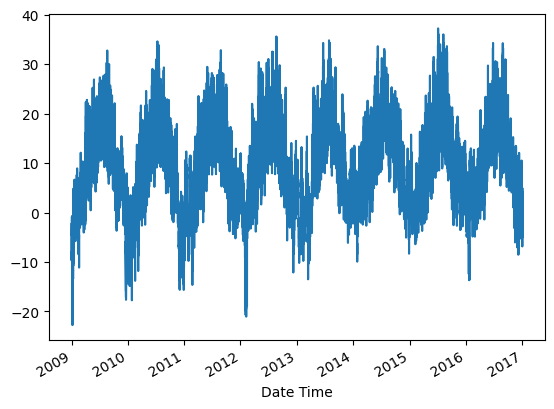

In [6]:
temp=data['T (degC)']
temp.plot()

<h2>Splitting the data</h2>
<p>Here, a window of 5 hours is taken as independent variables, and the record of the sixth hour is the value to be predicted. So the model can be defined as follows:</p>
$$f(T_{t},T_{t+1},T_{t+2},T_{t+3},T_{t+4})=\hat{T}_{t+5}$$

In [7]:
X_train,X_val,X_test,y_train,y_val,y_test = data_split(temp,5,0.7,0.1)

In [8]:
print('Train shape:',X_train.shape,',Validation shape:',X_val.shape,',Test shape:',X_test.shape)

Train shape: (49060, 5, 1) ,Validation shape: (2102, 5, 1) ,Test shape: (18924, 5, 1)


In [9]:
X_train[:5].T

array([[[-8.05, -8.88, -8.81, -9.05, -9.63],
        [-8.88, -8.81, -9.05, -9.63, -9.67],
        [-8.81, -9.05, -9.63, -9.67, -9.17],
        [-9.05, -9.63, -9.67, -9.17, -8.1 ],
        [-9.63, -9.67, -9.17, -8.1 , -7.66]]])

In [10]:
y_train[:5]

array([-9.67, -9.17, -8.1 , -7.66, -7.04])

In [11]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [12]:
model_1 = models.create_lstm_model((5,1))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________
None


2023-07-06 10:55:23.590939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-06 10:55:23.591921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-06 10:55:23.592546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [13]:
cp = ModelCheckpoint('model/', save_best_only=True)
model_1.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.001),
    metrics=['mean_absolute_error'])

In [ ]:
if os.path.exists('model/'):
    # Loading the model parameters.
    model = load_model('model/')
else:
    # Training the model.
    history = model_1.fit(
    X_train,
    y_train,
    validation_data=(
        X_val,
        y_val
    ),
    epochs=20,
    callbacks=[cp,
            keras.callbacks.EarlyStopping(
            patience=5
        )])

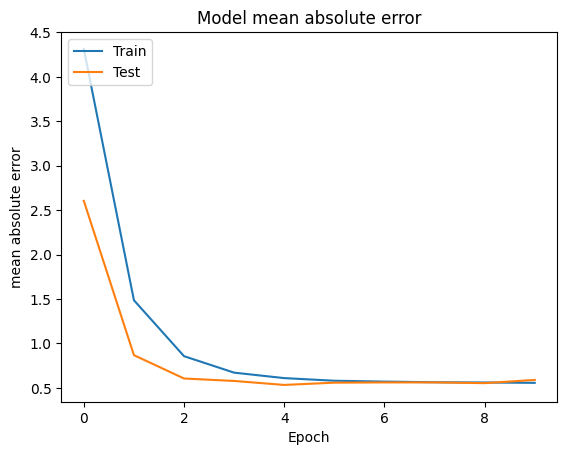

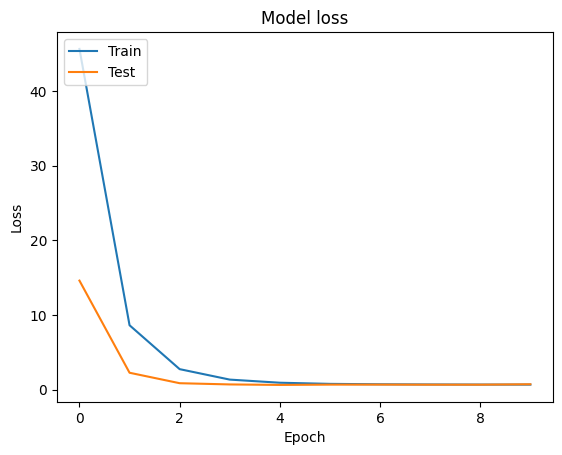

In [15]:
plot_history(history)

In [18]:
y_hat = model.predict(X_test)

 56/592 [=>............................] - ETA: 0s  

2023-07-06 10:56:56.847032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-06 10:56:56.847768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-06 10:56:56.848471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

592/592 [==============================] - 1s 876us/step


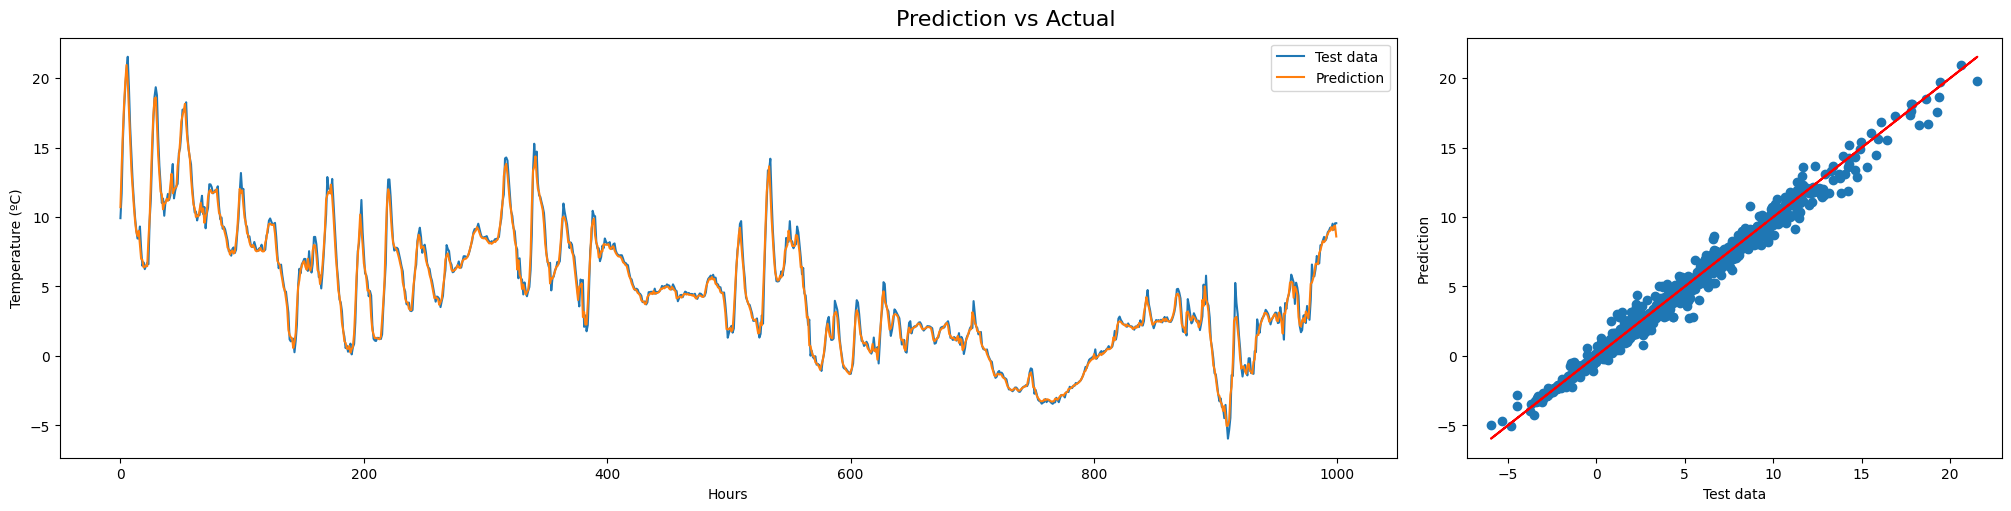

In [19]:
hat_vs_test(y_test[:1000],y_hat[:1000])